# Age of Empires II Match Data
---
## Introduction
---
Age of Empires II is one of the most popular online real-time strategy games of all time. It features an online ranked ladder where players build and manage their own empires and engage in battle with other players trying to do the same. Amidst an extremely competitive online scene and a wide variety of civilisations and maps to pick from, let us see if machine learning models can help us predict which games result in a win!

---
### Essential Libraries
We begin by importing essential Python Libraries and setting some optimal options for later.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
sb.set()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Preprocessing
---
### Import Datasets
We import the datasets retrieved from `https://www.kaggle.com/datasets/jerkeeler/age-of-empires-ii-de-match-data`.

In [2]:
matches = pd.read_csv('matches.csv')
matches

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration
0,B2c2Ad6Uf6TVL5uk,2,False,RM_1v1,39515,1575.00000,arabia,tiny,2,brazilsouth,0:23:30
1,eb8WdcbYlpeFLnoc,2,False,RM_TEAM,39515,2187.00000,arabia,large,8,eastus,0:32:48
2,tphUBvZ8eZBmai0L,2,False,RM_TEAM,39515,2450.00000,megarandom,large,8,brazilsouth,0:33:08
3,Kmhn0HZ8o8WwdXV9,1,False,RM_TEAM,39515,2387.00000,arabia,large,8,ukwest,0:25:51
4,U198Wdc3kzJPBVqh,1,False,RM_1v1,37906,1095.00000,acropolis,tiny,2,eastus,0:40:55
...,...,...,...,...,...,...,...,...,...,...,...
3153762,tsnfpZq8meetn9os,1,False,RM_TEAM,39515,1235.00000,mongolia,normal,6,eastus,1:01:32
3153763,WBshNzGipAiEBIEy,2,False,RM_1v1,37906,1177.00000,arabia,tiny,2,ukwest,0:22:01
3153764,skfmuZoDg1QPf9ZF,2,False,RM_1v1,37906,979.00000,four_lakes,tiny,2,eastus,0:36:44
3153765,Myta5GmtLaVV0PlW,1,False,RM_1v1,37906,973.00000,ghost_lake,tiny,2,eastus,0:22:46


In [3]:
matches.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153767 entries, 0 to 3153766
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   token           3153767 non-null  object 
 1   winning_team    3153767 non-null  int64  
 2   mirror          3153767 non-null  bool   
 3   ladder          3153767 non-null  object 
 4   patch           3153767 non-null  int64  
 5   average_rating  2990459 non-null  float64
 6   map             3153767 non-null  object 
 7   map_size        3153767 non-null  object 
 8   num_players     3153767 non-null  int64  
 9   server          3153767 non-null  object 
 10  duration        3153767 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 243.6+ MB


* There are `11` columns and `3153767` entries in this dataset.
* Our response variable is likely `winning_team`.
* `mirror` refers to whether or not there were multiple players playing as the same civilisation.
* `ladder` refers to what kind of game mode was played. May be used as a predictor.
* `patch` refers to what version the game was played on.
* `average_rating` refers to the average Elo rating of the players in that game. May be used as a predictor.
* `map` and `map_size` refers to the map that the game took place on. May be used as a predictor.
* `num_players` refers to the number of players in that game.
* `server` refers to the region where the game took place.
* `duration` refers to how long the game lasted. May be used as a predictor and determines what strategy the player could go for (eg. Rush, Boom).
---
### Exploratory Data Analysis & Data Cleaning
In Age of Empires II, extremely long drawn games can be very messy "trash wars". In these ridiculously long games, players have run out of the valuable 'gold' resource, are most likely experiencing much fatigue from the continuous cognitive stress, and are likely mindlessly throwing military units at each other's base. Using these games as part of our data's outliers may negatively affect our results. Therefore, we should consider removing these from our data.

In [4]:
# Convert "duration" column to datetime object in new column "duration_object"
matches["duration_object"] = pd.to_timedelta(matches["duration"])
matches

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration,duration_object
0,B2c2Ad6Uf6TVL5uk,2,False,RM_1v1,39515,1575.00000,arabia,tiny,2,brazilsouth,0:23:30,0 days 00:23:30
1,eb8WdcbYlpeFLnoc,2,False,RM_TEAM,39515,2187.00000,arabia,large,8,eastus,0:32:48,0 days 00:32:48
2,tphUBvZ8eZBmai0L,2,False,RM_TEAM,39515,2450.00000,megarandom,large,8,brazilsouth,0:33:08,0 days 00:33:08
3,Kmhn0HZ8o8WwdXV9,1,False,RM_TEAM,39515,2387.00000,arabia,large,8,ukwest,0:25:51,0 days 00:25:51
4,U198Wdc3kzJPBVqh,1,False,RM_1v1,37906,1095.00000,acropolis,tiny,2,eastus,0:40:55,0 days 00:40:55
...,...,...,...,...,...,...,...,...,...,...,...,...
3153762,tsnfpZq8meetn9os,1,False,RM_TEAM,39515,1235.00000,mongolia,normal,6,eastus,1:01:32,0 days 01:01:32
3153763,WBshNzGipAiEBIEy,2,False,RM_1v1,37906,1177.00000,arabia,tiny,2,ukwest,0:22:01,0 days 00:22:01
3153764,skfmuZoDg1QPf9ZF,2,False,RM_1v1,37906,979.00000,four_lakes,tiny,2,eastus,0:36:44,0 days 00:36:44
3153765,Myta5GmtLaVV0PlW,1,False,RM_1v1,37906,973.00000,ghost_lake,tiny,2,eastus,0:22:46,0 days 00:22:46


In [5]:
matches['duration_object'].describe()

count                      3153767
mean     0 days 02:45:48.011349601
std      1 days 05:15:50.484446663
min                0 days 00:00:01
25%                0 days 00:23:00
50%                0 days 00:30:44
75%                0 days 00:37:58
max               73 days 16:24:00
Name: duration_object, dtype: object

It appears that there are some peculiar outliers, for example a match that lasted a second, and a match that lasted 61 days!

In [6]:
# Convert duration to seconds and store in new column "duration_seconds"
matches["duration_seconds"] = matches["duration_object"].dt.total_seconds()
matches

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration,duration_object,duration_seconds
0,B2c2Ad6Uf6TVL5uk,2,False,RM_1v1,39515,1575.00000,arabia,tiny,2,brazilsouth,0:23:30,0 days 00:23:30,1410.00000
1,eb8WdcbYlpeFLnoc,2,False,RM_TEAM,39515,2187.00000,arabia,large,8,eastus,0:32:48,0 days 00:32:48,1968.00000
2,tphUBvZ8eZBmai0L,2,False,RM_TEAM,39515,2450.00000,megarandom,large,8,brazilsouth,0:33:08,0 days 00:33:08,1988.00000
3,Kmhn0HZ8o8WwdXV9,1,False,RM_TEAM,39515,2387.00000,arabia,large,8,ukwest,0:25:51,0 days 00:25:51,1551.00000
4,U198Wdc3kzJPBVqh,1,False,RM_1v1,37906,1095.00000,acropolis,tiny,2,eastus,0:40:55,0 days 00:40:55,2455.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3153762,tsnfpZq8meetn9os,1,False,RM_TEAM,39515,1235.00000,mongolia,normal,6,eastus,1:01:32,0 days 01:01:32,3692.00000
3153763,WBshNzGipAiEBIEy,2,False,RM_1v1,37906,1177.00000,arabia,tiny,2,ukwest,0:22:01,0 days 00:22:01,1321.00000
3153764,skfmuZoDg1QPf9ZF,2,False,RM_1v1,37906,979.00000,four_lakes,tiny,2,eastus,0:36:44,0 days 00:36:44,2204.00000
3153765,Myta5GmtLaVV0PlW,1,False,RM_1v1,37906,973.00000,ghost_lake,tiny,2,eastus,0:22:46,0 days 00:22:46,1366.00000


In [7]:
# Remove outliers (data outside 1.5 times of IQR)
iqr = matches[['duration_seconds']].quantile(0.75) - matches[['duration_seconds']].quantile(0.25)
outliers = matches.loc[(matches['duration_seconds'] < matches['duration_seconds'].quantile(0.25) - 1.5 * iqr['duration_seconds']) | (matches['duration_seconds'] > matches['duration_seconds'].quantile(0.75) + 1.5 * iqr['duration_seconds'])]
clean_data = matches.drop(outliers.index)
clean_data

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration,duration_object,duration_seconds
0,B2c2Ad6Uf6TVL5uk,2,False,RM_1v1,39515,1575.00000,arabia,tiny,2,brazilsouth,0:23:30,0 days 00:23:30,1410.00000
1,eb8WdcbYlpeFLnoc,2,False,RM_TEAM,39515,2187.00000,arabia,large,8,eastus,0:32:48,0 days 00:32:48,1968.00000
2,tphUBvZ8eZBmai0L,2,False,RM_TEAM,39515,2450.00000,megarandom,large,8,brazilsouth,0:33:08,0 days 00:33:08,1988.00000
3,Kmhn0HZ8o8WwdXV9,1,False,RM_TEAM,39515,2387.00000,arabia,large,8,ukwest,0:25:51,0 days 00:25:51,1551.00000
4,U198Wdc3kzJPBVqh,1,False,RM_1v1,37906,1095.00000,acropolis,tiny,2,eastus,0:40:55,0 days 00:40:55,2455.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3153761,AhJRM1UXjA5fpCDM,2,False,RM_1v1,37906,1282.00000,golden_pit,tiny,2,australiasoutheast,0:16:27,0 days 00:16:27,987.00000
3153763,WBshNzGipAiEBIEy,2,False,RM_1v1,37906,1177.00000,arabia,tiny,2,ukwest,0:22:01,0 days 00:22:01,1321.00000
3153764,skfmuZoDg1QPf9ZF,2,False,RM_1v1,37906,979.00000,four_lakes,tiny,2,eastus,0:36:44,0 days 00:36:44,2204.00000
3153765,Myta5GmtLaVV0PlW,1,False,RM_1v1,37906,973.00000,ghost_lake,tiny,2,eastus,0:22:46,0 days 00:22:46,1366.00000


In [8]:
clean_data['duration_object'].describe()

count                      3013233
mean     0 days 00:29:48.549107885
std      0 days 00:11:03.449996269
min                0 days 00:00:33
25%                0 days 00:22:39
50%                0 days 00:30:10
75%                0 days 00:36:48
max                0 days 01:00:25
Name: duration_object, dtype: object

<AxesSubplot:>

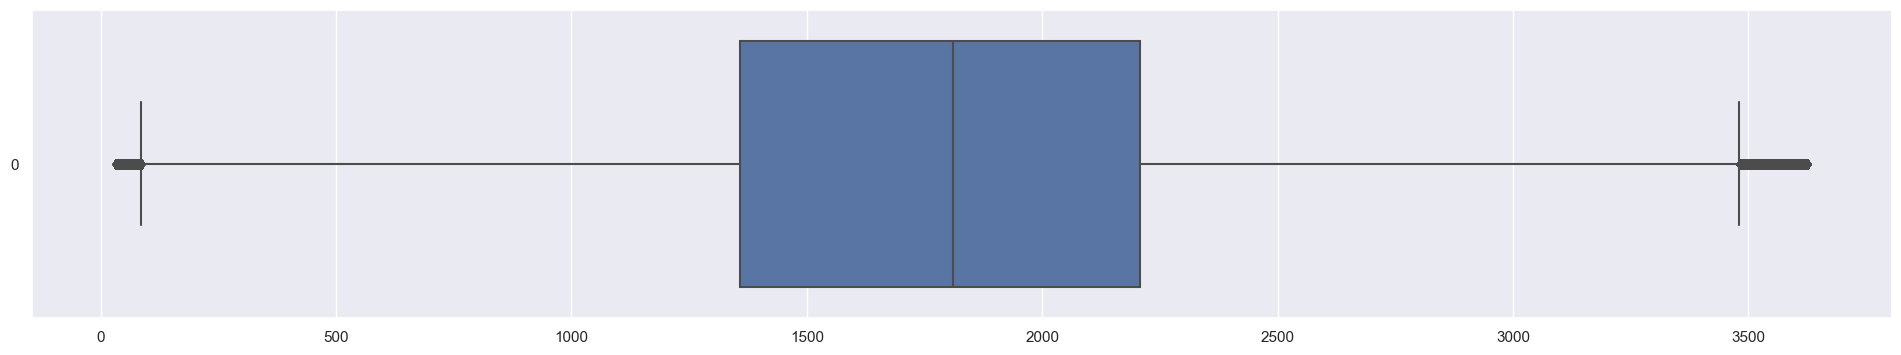

In [9]:
plt.figure(figsize=(24, 4))
sb.boxplot(data = clean_data['duration_seconds'], orient = 'h')

As seen above, now the new min time is 46s, which is far more reasonable as that is around the time players' scouts (cavalry unit in the game) start fighting. The new max time is about 1h, which makes far more sense. The mean game time is now around 30min which is definitely very reasonable (much better than the previous 1h 45min!).

---
Now we will import the second csv file that contains specific match info like which civ was played, who won etc.

In [10]:
players = pd.read_csv('match_players.csv')
players

,token,match,rating,color,civ,team,winner
0,rFWxLAdY6TF78xlo,axps4XstiBOmrDeG,1565.00000,Red,Chinese,1,False
1,zsyvxRyzLh85YIba,axps4XstiBOmrDeG,1600.00000,Blue,Goths,2,True
2,CHrJISNtjKDKM114,uQdosqwC7uiQ78ya,2145.00000,Orange,Incas,1,False
3,X147inwVdQuaegxT,uQdosqwC7uiQ78ya,2124.00000,Green,Tatars,2,True
4,kNckdaCe6pjKm6Au,uQdosqwC7uiQ78ya,2105.00000,Red,Magyars,1,False
...,...,...,...,...,...,...,...
9732495,RAUSAMAC1Y23giS0,6UKYvPeVo9Fj0a9X,1093.00000,Blue,Lithuanians,2,False
9732496,3T6Wd6AfWjkeAY9D,dLVzMIoR9tRPCsMt,1111.00000,Red,Berbers,1,True
9732497,dYutMIrm0Asa8E2v,dLVzMIoR9tRPCsMt,1124.00000,Blue,Ethiopians,2,False
9732498,9C8tY2D2STKtqPAQ,Twm8bklVwkEGYjFd,1152.00000,Red,Malians,1,False


In [11]:
players.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9732500 entries, 0 to 9732499
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   token   9732500 non-null  object 
 1   match   9732500 non-null  object 
 2   rating  9229056 non-null  float64
 3   color   9732499 non-null  object 
 4   civ     9732500 non-null  object 
 5   team    9732500 non-null  int64  
 6   winner  9732500 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 454.8+ MB


* `rating` refers to the player's Elo rating. The higher the number, the more skilled the player is.
* `color` refers to the player's choice of color. Perhaps certain colors have a perceived benefit of better unit visibility?
* `civ` refers to the player's civilisation. Different civilisations will have different strengths and weaknesses and affects the odds of winning the game.
---
We merge the dataframes together. We match them based on the `token` column in `clean_data` and the corresponding `match` column in `players`. Note the identical columns in both dataframes `token` - they refer to different things and we have separated them into `token_player` and `token_match`.

In [12]:
joined_data = pd.merge(players, clean_data, left_on = "match", right_on = "token", suffixes = ["_player", "_match"])
joined_data

,token_player,match,rating,color,civ,team,winner,token_match,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration,duration_object,duration_seconds
0,rFWxLAdY6TF78xlo,axps4XstiBOmrDeG,1565.00000,Red,Chinese,1,False,axps4XstiBOmrDeG,2,False,RM_1v1,37906,1583.00000,arabia,tiny,2,ukwest,0:34:17,0 days 00:34:17,2057.00000
1,zsyvxRyzLh85YIba,axps4XstiBOmrDeG,1600.00000,Blue,Goths,2,True,axps4XstiBOmrDeG,2,False,RM_1v1,37906,1583.00000,arabia,tiny,2,ukwest,0:34:17,0 days 00:34:17,2057.00000
2,CHrJISNtjKDKM114,uQdosqwC7uiQ78ya,2145.00000,Orange,Incas,1,False,uQdosqwC7uiQ78ya,2,False,RM_TEAM,37906,2133.00000,gold_rush,medium,4,brazilsouth,0:39:30,0 days 00:39:30,2370.00000
3,X147inwVdQuaegxT,uQdosqwC7uiQ78ya,2124.00000,Green,Tatars,2,True,uQdosqwC7uiQ78ya,2,False,RM_TEAM,37906,2133.00000,gold_rush,medium,4,brazilsouth,0:39:30,0 days 00:39:30,2370.00000
4,kNckdaCe6pjKm6Au,uQdosqwC7uiQ78ya,2105.00000,Red,Magyars,1,False,uQdosqwC7uiQ78ya,2,False,RM_TEAM,37906,2133.00000,gold_rush,medium,4,brazilsouth,0:39:30,0 days 00:39:30,2370.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241789,RAUSAMAC1Y23giS0,6UKYvPeVo9Fj0a9X,1093.00000,Blue,Lithuanians,2,False,6UKYvPeVo9Fj0a9X,1,False,RM_1v1,39515,NaN,arena,tiny,2,southeastasia,0:27:19,0 days 00:27:19,1639.00000
9241790,3T6Wd6AfWjkeAY9D,dLVzMIoR9tRPCsMt,1111.00000,Red,Berbers,1,True,dLVzMIoR9tRPCsMt,1,False,RM_1v1,39515,NaN,hideout,tiny,2,southeastasia,0:23:42,0 days 00:23:42,1422.00000
9241791,dYutMIrm0Asa8E2v,dLVzMIoR9tRPCsMt,1124.00000,Blue,Ethiopians,2,False,dLVzMIoR9tRPCsMt,1,False,RM_1v1,39515,NaN,hideout,tiny,2,southeastasia,0:23:42,0 days 00:23:42,1422.00000
9241792,9C8tY2D2STKtqPAQ,Twm8bklVwkEGYjFd,1152.00000,Red,Malians,1,False,Twm8bklVwkEGYjFd,2,False,RM_1v1,39515,NaN,arena,tiny,2,westindia,0:27:56,0 days 00:27:56,1676.00000


In [13]:
joined_data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9241794 entries, 0 to 9241793
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype          
---  ------            --------------    -----          
 0   token_player      9241794 non-null  object         
 1   match             9241794 non-null  object         
 2   rating            8781324 non-null  float64        
 3   color             9241793 non-null  object         
 4   civ               9241794 non-null  object         
 5   team              9241794 non-null  int64          
 6   winner            9241794 non-null  bool           
 7   token_match       9241794 non-null  object         
 8   winning_team      9241794 non-null  int64          
 9   mirror            9241794 non-null  bool           
 10  ladder            9241794 non-null  object         
 11  patch             9241794 non-null  int64          
 12  average_rating    8736698 non-null  float64        
 13  map               9241794 n

### Cleaning NULL Values
There are null values for Elo ratings. These could refer to unrated games not part of the ranked ladder, or players new to ranked. As such, we will be removing these rows because in these games, players may not be playing at a serious competitive level and this may make the data unreliable.

In [14]:
joined_data = joined_data.dropna()
joined_data = joined_data.reset_index(drop=True)
joined_data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8302413 entries, 0 to 8302412
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype          
---  ------            --------------    -----          
 0   token_player      8302413 non-null  object         
 1   match             8302413 non-null  object         
 2   rating            8302413 non-null  float64        
 3   color             8302413 non-null  object         
 4   civ               8302413 non-null  object         
 5   team              8302413 non-null  int64          
 6   winner            8302413 non-null  bool           
 7   token_match       8302413 non-null  object         
 8   winning_team      8302413 non-null  int64          
 9   mirror            8302413 non-null  bool           
 10  ladder            8302413 non-null  object         
 11  patch             8302413 non-null  int64          
 12  average_rating    8302413 non-null  float64        
 13  map               8302413 n

### Exploring Response Variable
To explore our response varaible `winner`, we can plot a bar graph. It shows an even distribution between matches won and lost, which is to be expected and is good.

Ratio of L : W =  4169623 : 4132790


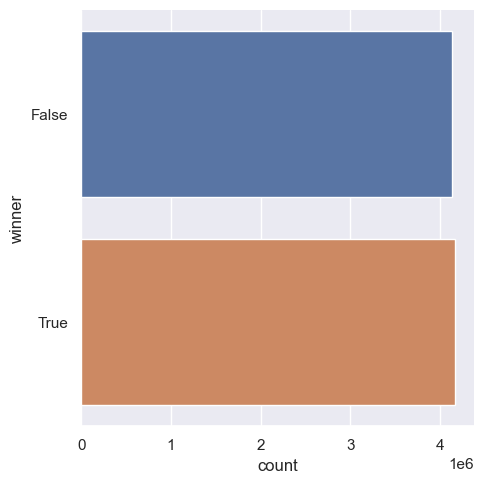

In [15]:
countL, countW = joined_data['winner'].value_counts()
print("Ratio of L : W = ", countL, ":", countW)
sb.catplot(y = 'winner', data = joined_data, kind = "count")

### Relationship between map played and civ won
We can plot a table and heatmap of correlation between map played and civ won to see how different civs perform differently on different maps. One interesting example is how Mongols perform very poorly on water_nomad, which makes sense because they don't have water related civ bonuses and even lack key upgrades for water-play.

map,acropolis,alpine_lakes,arabia,archipelago,arena,baltic,black_forest,bog_islands,budapest,cenotes,...,rivers,scandinavia,serengeti,socotra,steppe,team_islands,valley,water_nomad,wolf_hill,yucatan
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.49438,0.51852,0.50183,0.50000,0.51779,0.48410,0.49494,0.46944,0.47619,0.50249,...,0.50943,0.48438,0.51228,0.52902,0.49300,0.46503,0.50086,0.36364,0.52375,0.48786
Berbers,0.53404,0.48536,0.51199,0.54639,0.46175,0.54885,0.46752,0.51799,0.50455,0.49001,...,0.48980,0.50328,0.51164,0.49454,0.51831,0.53116,0.51174,0.43077,0.47280,0.48312
Britons,0.48109,0.45888,0.50569,0.51534,0.49475,0.48714,0.48754,0.39324,0.49806,0.51755,...,0.51385,0.49165,0.49591,0.49330,0.50049,0.44431,0.49818,0.50735,0.50803,0.49576
Bulgarians,0.51317,0.49878,0.48791,0.50725,0.50732,0.50000,0.50403,0.45070,0.48175,0.51724,...,0.46667,0.49042,0.50156,0.49061,0.47813,0.53333,0.48928,0.39286,0.49380,0.48319
Burmese,0.45821,0.47904,0.48236,0.40678,0.55254,0.48731,0.50664,0.41727,0.49558,0.48214,...,0.46392,0.47274,0.46985,0.51040,0.52721,0.50490,0.44033,0.52174,0.50545,0.49621
Byzantines,0.48519,0.50380,0.46404,0.50993,0.46896,0.51985,0.46207,0.53834,0.52973,0.48792,...,0.44444,0.46270,0.46741,0.45361,0.44828,0.51787,0.47890,0.65432,0.46539,0.47007
Celts,0.50119,0.53162,0.51783,0.50862,0.52155,0.46134,0.51984,0.43501,0.45178,0.50645,...,0.49254,0.48108,0.52208,0.51077,0.50605,0.51188,0.50587,0.40260,0.47200,0.48336
Chinese,0.46078,0.47761,0.48585,0.37179,0.47813,0.43426,0.47215,0.43600,0.55714,0.48889,...,0.51034,0.48605,0.46158,0.46017,0.53049,0.48539,0.47831,0.44444,0.50234,0.48353
Cumans,0.48652,0.47215,0.47593,0.47059,0.50392,0.45483,0.48557,0.45378,0.44000,0.46347,...,0.50000,0.49803,0.45934,0.43528,0.48458,0.50116,0.49235,0.35000,0.46868,0.50957


<AxesSubplot:xlabel='map', ylabel='civ'>

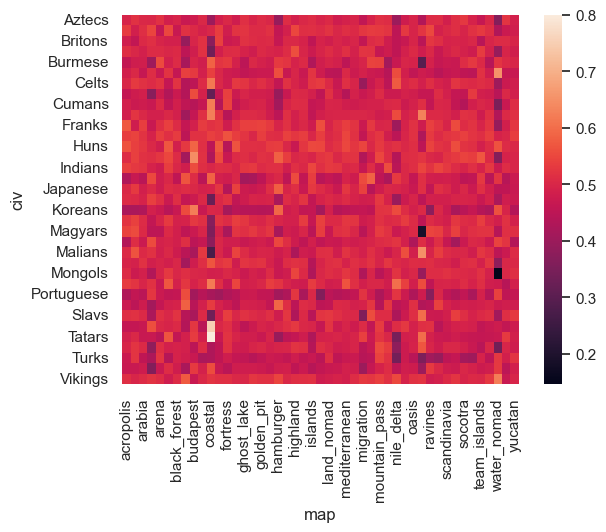

In [16]:
win_maps = joined_data.pivot_table(values="winner", index="civ", columns="map")
display(win_maps)
sb.heatmap(win_maps)

## Methodology & Experiments
---
### Creating The Machine Learning Model: Attempt 1 (Baseline Model)
We will use a **classification tree model** because our response variable is `winner`, which is of type `bool`. 6 predictors are listed below. We chose these 6 as they are likely factors that affect who wins the game.
> **Response Variable** : `winner`  
> **Predictor Features** :
> `color` - some colors may make friend and foe units clearer to distinguish, giving players the advantage  
> `civ` - different civilisations have different bonuses and flaws  
> `rating` - how skilled a player is affects probability of winning  
> `ladder` - the game mode changes the way the game is played  
> `map` - some maps are 'closed', some maps are 'open', some maps have land, water or are hybrid etc.  
> `duration_seconds` - how long the match lasted may be an indication of what strategy was employed (rush, boom, fast castle etc.)  

Note that `color`, `civ`, `ladder` and `map` are categorical. We need to encode them as integers because `DecisionTreeClassifier` does not handle categorical variables directly. To do that, we will use `OneHotEncoding`.

In [17]:
ohe = OneHotEncoder()
joined_data_cat = joined_data[['color', 'civ', 'ladder', 'map']]
ohe.fit(joined_data_cat)
joined_data_cat_ohe = pd.DataFrame(ohe.transform(joined_data_cat).toarray(), columns = ohe.get_feature_names_out(joined_data_cat.columns))
joined_data_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8302413 entries, 0 to 8302412
Data columns (total 92 columns):
 #   Column               Dtype  
---  ------               -----  
 0   color_Blue           float64
 1   color_Cyan           float64
 2   color_Green          float64
 3   color_Grey           float64
 4   color_Orange         float64
 5   color_Purple         float64
 6   color_Red            float64
 7   color_Yellow         float64
 8   civ_Aztecs           float64
 9   civ_Berbers          float64
 10  civ_Britons          float64
 11  civ_Bulgarians       float64
 12  civ_Burmese          float64
 13  civ_Byzantines       float64
 14  civ_Celts            float64
 15  civ_Chinese          float64
 16  civ_Cumans           float64
 17  civ_Ethiopians       float64
 18  civ_Franks           float64
 19  civ_Goths            float64
 20  civ_Huns             float64
 21  civ_Incas            float64
 22  civ_Indians          float64
 23  civ_Italians         float64
 24

Now we combine the numerical and encoded categorical variables.

In [18]:
joined_data_num = joined_data[['rating', 'duration_seconds']]
joined_data_res = joined_data['winner']
joined_data_ohe = pd.concat([joined_data_num, joined_data_cat_ohe, joined_data_res], sort = False, axis = 1).reindex(index = joined_data_num.index)
joined_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8302413 entries, 0 to 8302412
Data columns (total 95 columns):
 #   Column               Dtype  
---  ------               -----  
 0   rating               float64
 1   duration_seconds     float64
 2   color_Blue           float64
 3   color_Cyan           float64
 4   color_Green          float64
 5   color_Grey           float64
 6   color_Orange         float64
 7   color_Purple         float64
 8   color_Red            float64
 9   color_Yellow         float64
 10  civ_Aztecs           float64
 11  civ_Berbers          float64
 12  civ_Britons          float64
 13  civ_Bulgarians       float64
 14  civ_Burmese          float64
 15  civ_Byzantines       float64
 16  civ_Celts            float64
 17  civ_Chinese          float64
 18  civ_Cumans           float64
 19  civ_Ethiopians       float64
 20  civ_Franks           float64
 21  civ_Goths            float64
 22  civ_Huns             float64
 23  civ_Incas            float64
 24

Now we create and fit the `DecisionTreeClassifier` model.

[Text(0.5, 0.9, 'civ_Franks <= 0.5\ngini = 0.5\nsamples = 5811689\nvalue = [2893738, 2917951]\nclass = Win'),
 Text(0.25, 0.7, 'civ_Goths <= 0.5\ngini = 0.5\nsamples = 5352813\nvalue = [2676652, 2676161]\nclass = Loss'),
 Text(0.125, 0.5, 'rating <= 2697.5\ngini = 0.5\nsamples = 5069032\nvalue = [2542190, 2526842]\nclass = Loss'),
 Text(0.0625, 0.3, 'civ_Koreans <= 0.5\ngini = 0.5\nsamples = 5044558\nvalue = [2531807, 2512751]\nclass = Loss'),
 Text(0.03125, 0.1, 'gini = 0.5\nsamples = 4980187\nvalue = [2496614, 2483573]\nclass = Loss'),
 Text(0.09375, 0.1, 'gini = 0.496\nsamples = 64371\nvalue = [35193, 29178]\nclass = Loss'),
 Text(0.1875, 0.3, 'rating <= 2806.5\ngini = 0.489\nsamples = 24474\nvalue = [10383, 14091]\nclass = Win'),
 Text(0.15625, 0.1, 'gini = 0.495\nsamples = 14451\nvalue = [6483, 7968]\nclass = Win'),
 Text(0.21875, 0.1, 'gini = 0.475\nsamples = 10023\nvalue = [3900, 6123]\nclass = Win'),
 Text(0.375, 0.5, 'ladder_RM_1v1 <= 0.5\ngini = 0.499\nsamples = 283781\nvalue

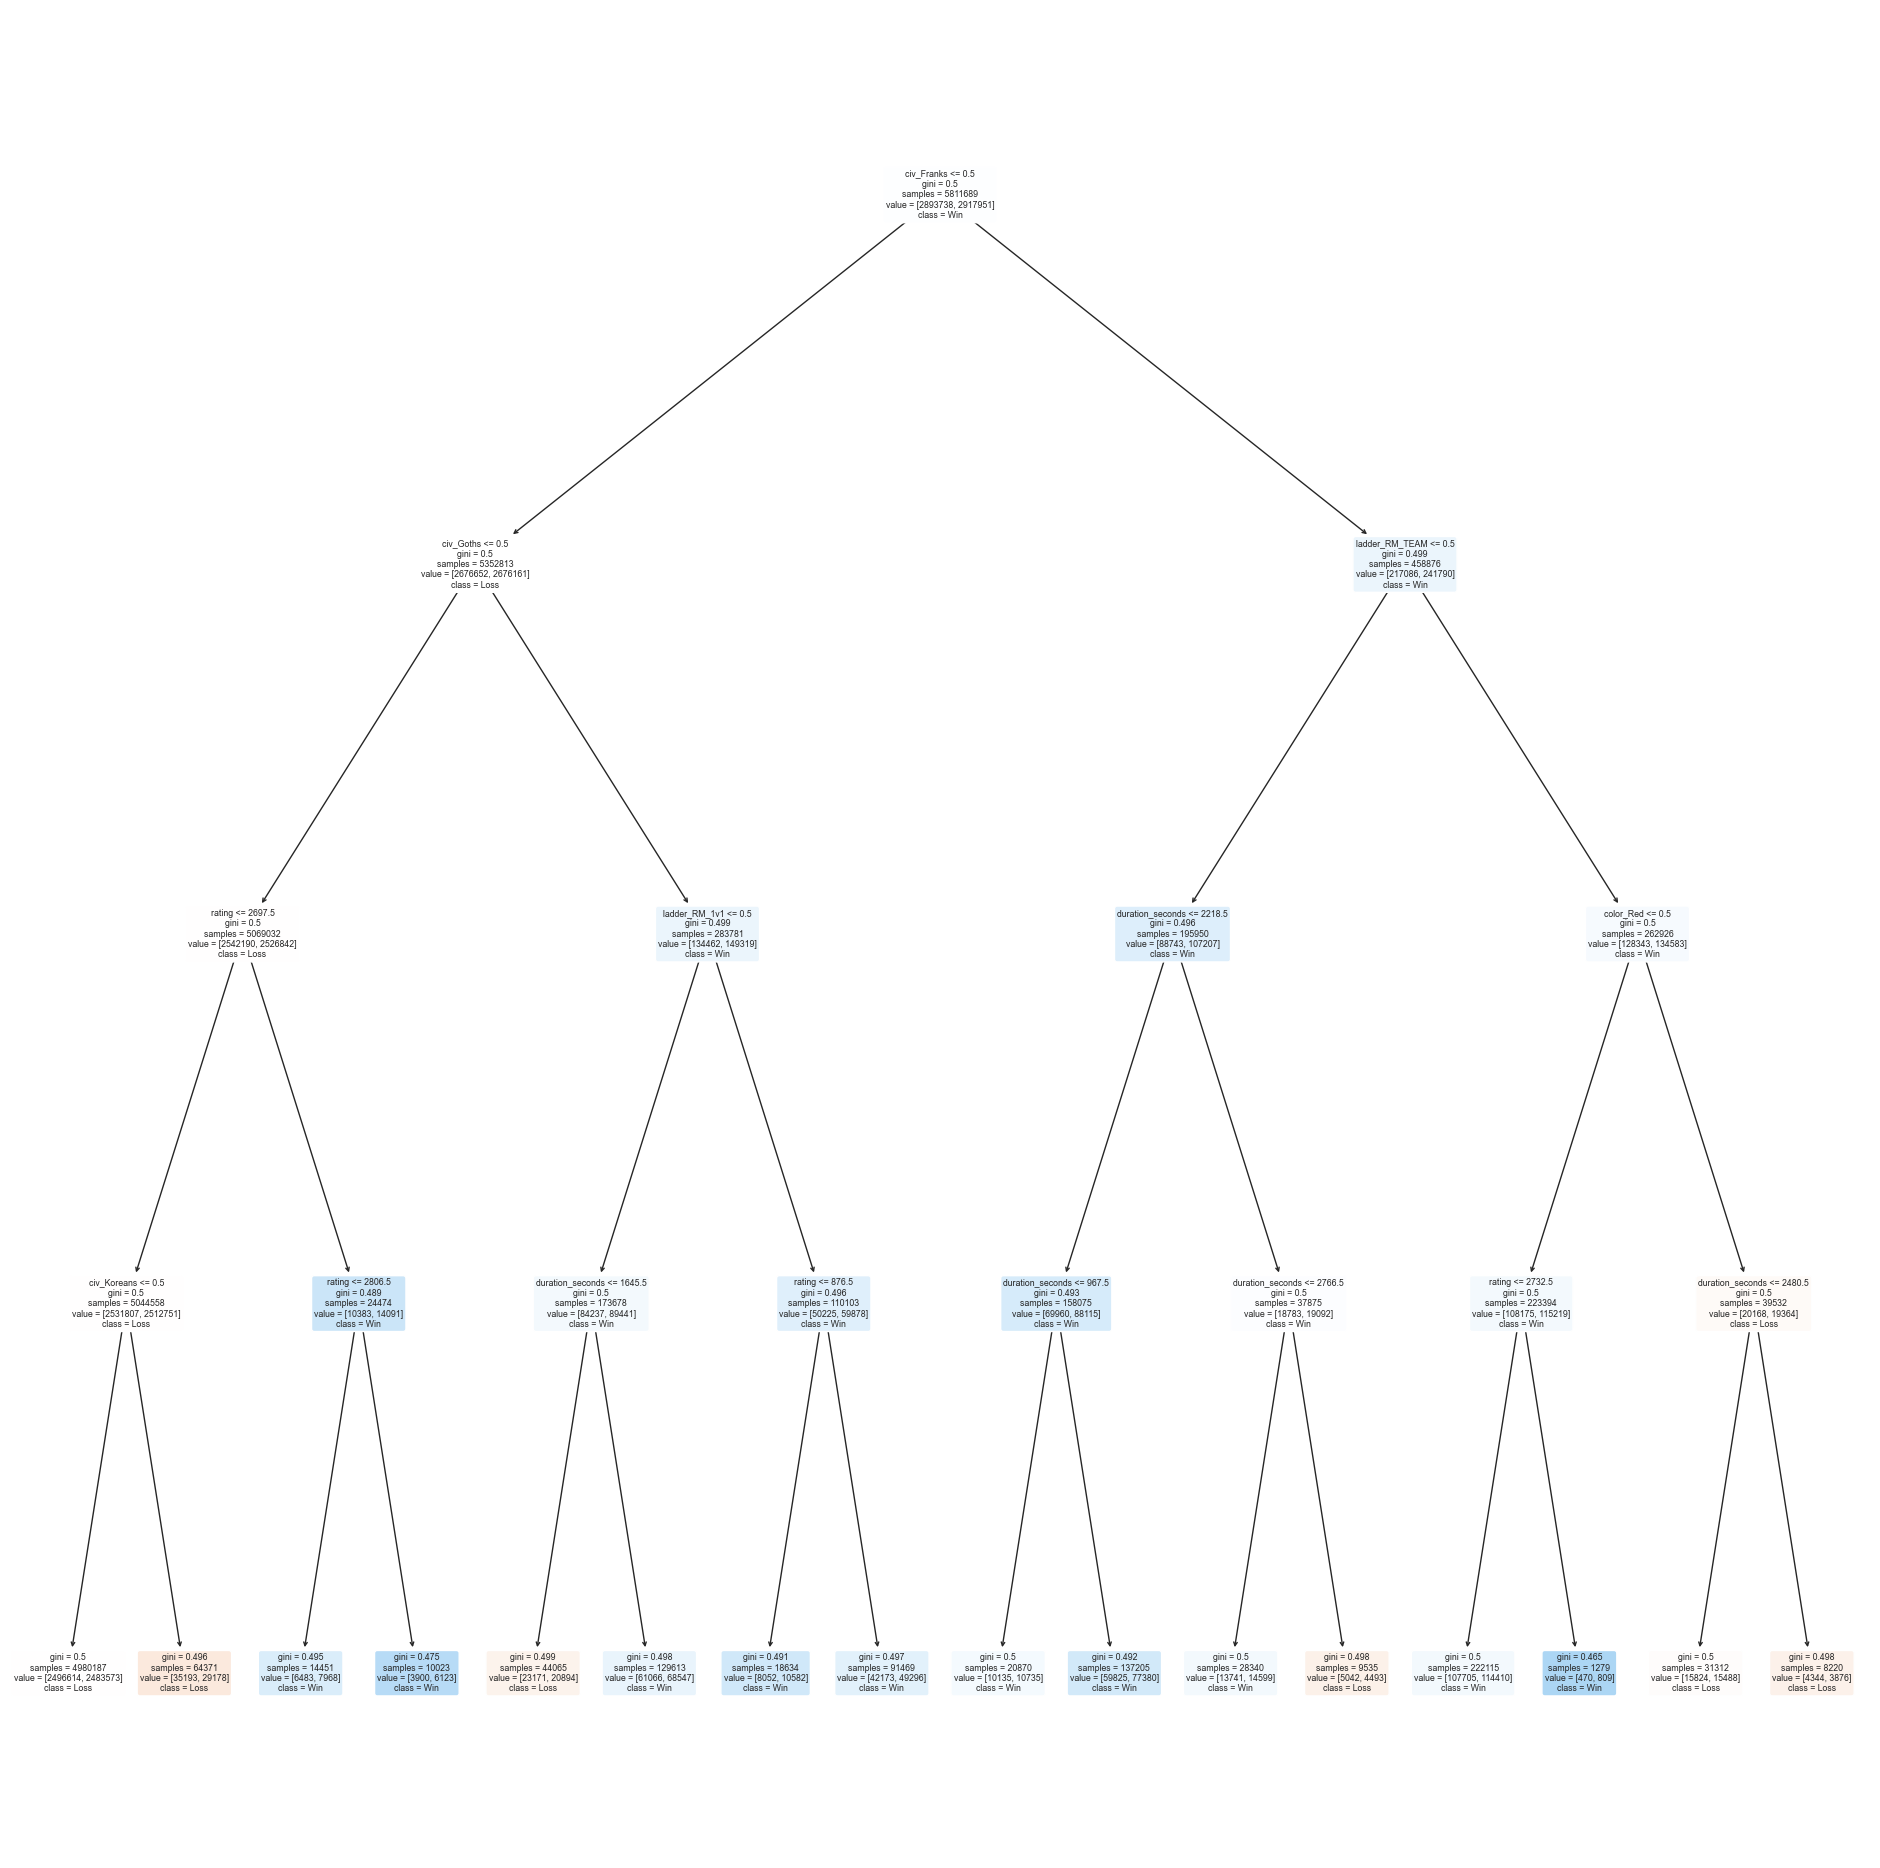

In [19]:
y = pd.DataFrame(joined_data_ohe['winner'])
x = pd.DataFrame(joined_data_ohe.drop('winner', axis = 1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
dectree = DecisionTreeClassifier(max_depth = 4)
dectree.fit(x_train, y_train)
plt.figure(figsize=(24,24))
plot_tree(dectree, filled = True, rounded = True, feature_names = x_train.columns, class_names = ["Loss", "Win"])

### Check accuracy of model on train data
We will print the confusion matrix and accuracy measures to check the model's accuracy, starting with the train data.

Classification Accuracy: 0.5059866417490682
TPR: 0.12352811956060948
TNR: 0.8916453390044295

FPR: 0.10835466099557044
FNR: 0.8764718804393905


<AxesSubplot:>

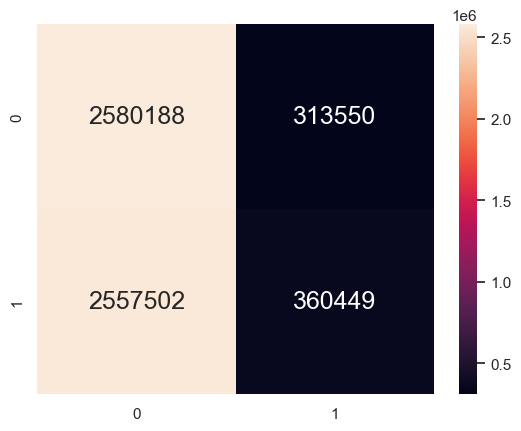

In [20]:
y_train_pred = dectree.predict(x_train)
print("Classification Accuracy:", dectree.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Check accuracy of model on test data
We do the same for test data.

Classification Accuracy: 0.5053683186093682
TPR: 0.12335899500827693
TNR: 0.8912684859069676

FPR: 0.10873151409303242
FNR: 0.876641004991723


<AxesSubplot:>

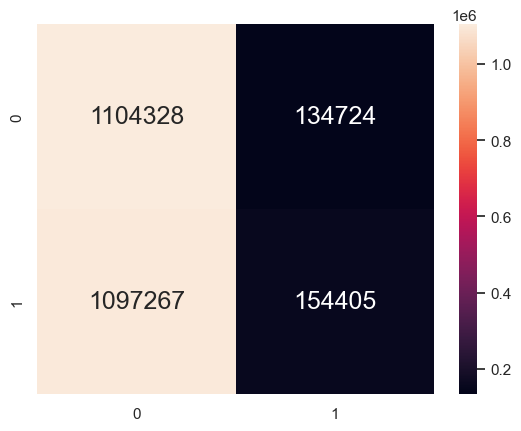

In [21]:
y_test_pred = dectree.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Analysis
At a standard low depth of 4, it is clear that our model is very bad because classification acccuracy is about 0.50 for both train and test data. This means half the time it is making the wrong prediction. Furthermore, despite the ratio of actual wins to losses to be about 50:50, this model is predicting a huge majority of games to be 'Loss' compared to 'Win'.

---
### Creating The Machine Learning Model: Attempt 2
Given that we have a lot of predictor variables and data entries, we need to increase the depth to make our model more accurate.

In [22]:
dectree = DecisionTreeClassifier(max_depth = 8)
dectree.fit(x_train, y_train)
plt.figure(figsize=(24,24))
plot_tree(dectree, filled = True, rounded = True, feature_names = x_train.columns, class_names = ["Loss", "Win"])

'\ndectree = DecisionTreeClassifier(max_depth = 8)\ndectree.fit(x_train, y_train)\nplt.figure(figsize=(24,24))\nplot_tree(dectree, filled = True, rounded = True, feature_names = x_train.columns, class_names = ["Loss", "Win"])\n'

**Note**: The classification tree took a very long time to print because of the relatively higher depth. Something to keep in mind.

---
### Check accuracy of model on train data

Classification Accuracy: 0.5059866417490682
TPR: 0.12352811956060948
TNR: 0.8916453390044295

FPR: 0.10835466099557044
FNR: 0.8764718804393905


<AxesSubplot:>

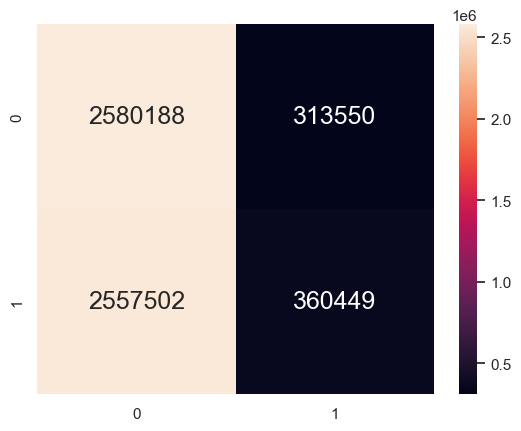

In [23]:
y_train_pred = dectree.predict(x_train)
print("Classification Accuracy:", dectree.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Check accuracy of model on test data

Classification Accuracy: 0.5053683186093682
TPR: 0.12335899500827693
TNR: 0.8912684859069676

FPR: 0.10873151409303242
FNR: 0.876641004991723


<AxesSubplot:>

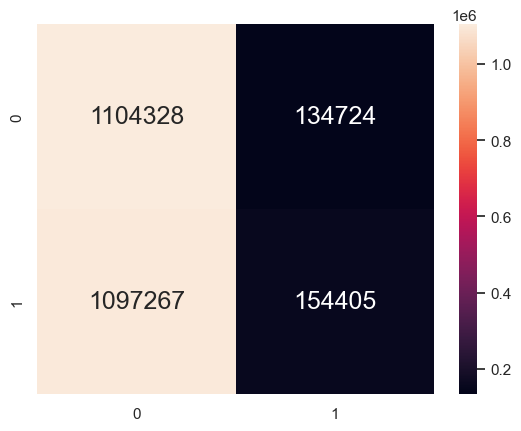

In [24]:
y_test_pred = dectree.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Analysis
Attempt 2 is better than the baseline attempt. This is because of the increased depth. Classification accuracy has gone up for both train and test data. Looking at the confusion matrix, it is definitely a lot less skewed towards one side now and is more balanced, specifically the false positive and false negative rates. The model can still be better though.

---
### Creating The Machine Learning Model: Attempt 3
As mentioned above, a major problem with the earlier models is the size of the data we were working with. Because the amount of data we fed as input was very large (a few million entries), increasing the depth of the decision tree made the code take a very long time to finish running. Hence, for this attempt, we will bring down the scale of our machine learning model by taking a smaller sample of data. We will also be using less predictors, removing `color` and `ladder`. The reason for using less predictors is to try and reduce overfitting. As we bring down the number of entries, we can increase the depth of our tree. By increasing the depth, the tree will have more splits and branches, complicating the model further. We remove these predictors to reduce the random noise and fluctuations in our data. While trying to strike a balance between the number of predictor features and the complexity of our model, our intuition tells us that predictors like `civ` should still be used because it intuitively affects the way the game is played the most.

[Text(0.8997366354401148, 0.9848484848484849, 'rating <= 2567.5\ngini = 0.5\nsamples = 70000\nvalue = [34766, 35234]\nclass = Win'),
 Text(0.8059084170767149, 0.9545454545454546, 'civ_Franks <= 0.5\ngini = 0.5\nsamples = 69186\nvalue = [34429, 34757]\nclass = Win'),
 Text(0.692732920904523, 0.9242424242424242, 'civ_Goths <= 0.5\ngini = 0.5\nsamples = 63625\nvalue = [31804, 31821]\nclass = Win'),
 Text(0.6585892411836671, 0.8939393939393939, 'civ_Koreans <= 0.5\ngini = 0.5\nsamples = 60167\nvalue = [30192, 29975]\nclass = Loss'),
 Text(0.6112498495116683, 0.8636363636363636, 'civ_Portuguese <= 0.5\ngini = 0.5\nsamples = 59375\nvalue = [29747, 29628]\nclass = Loss'),
 Text(0.5548151710762365, 0.8333333333333334, 'civ_Huns <= 0.5\ngini = 0.5\nsamples = 58624\nvalue = [29325, 29299]\nclass = Loss'),
 Text(0.4747261154571328, 0.803030303030303, 'duration_seconds <= 2467.5\ngini = 0.5\nsamples = 56225\nvalue = [28202, 28023]\nclass = Loss'),
 Text(0.3869011151621067, 0.7727272727272727, 'dur

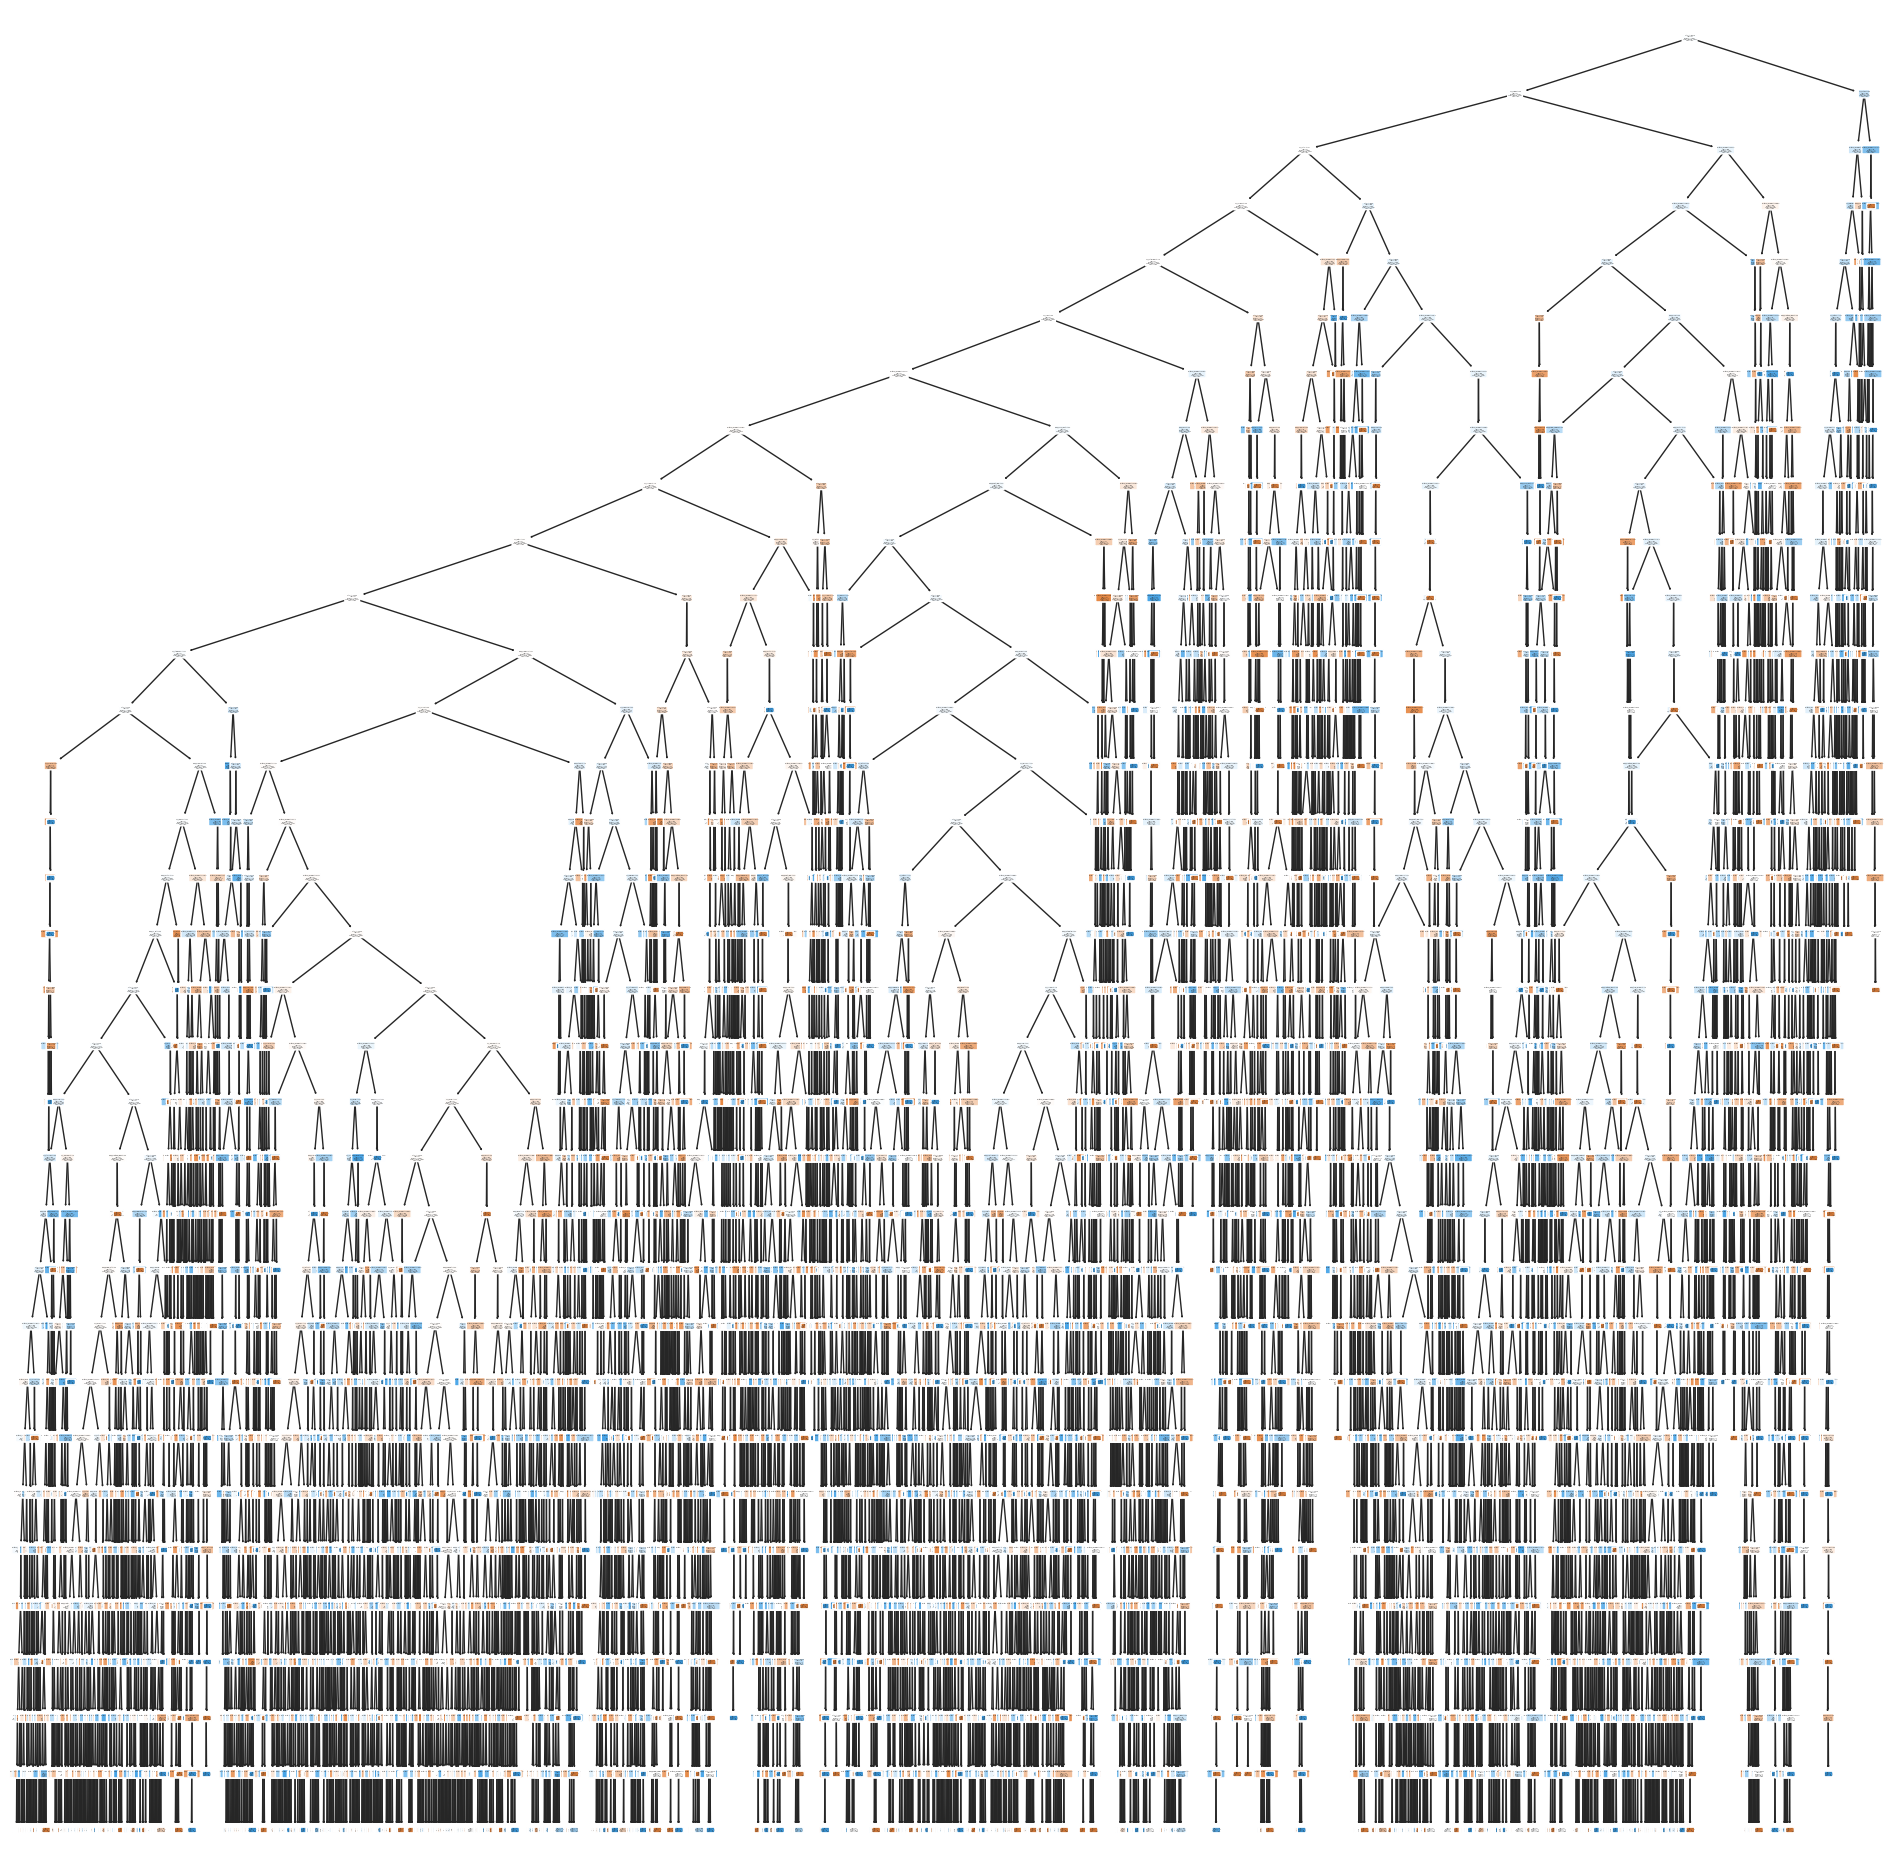

In [25]:
sample_data = joined_data.sample(n=100000).reset_index(drop = True)
ohe = OneHotEncoder()
sample_data_cat = sample_data[['civ', 'map']]
ohe.fit(sample_data_cat)
sample_data_cat_ohe = pd.DataFrame(ohe.transform(sample_data_cat).toarray(), columns = ohe.get_feature_names_out(sample_data_cat.columns))
sample_data_num = sample_data[['rating', 'duration_seconds']]
sample_data_res = sample_data['winner']
sample_data_ohe = pd.concat([sample_data_num, sample_data_cat_ohe, sample_data_res], sort = False, axis = 1).reindex(index = sample_data_num.index)
y = pd.DataFrame(sample_data_ohe['winner'])
x = pd.DataFrame(sample_data_ohe.drop('winner', axis = 1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
dectree = DecisionTreeClassifier(max_depth = 32)
dectree.fit(x_train, y_train)
plt.figure(figsize=(24,24))
plot_tree(dectree, filled = True, rounded = True, feature_names = x_train.columns, class_names = ["Loss", "Win"])

### Check accuracy of model on train data

Classification Accuracy: 0.6826428571428571
TPR: 0.5477379803598796
TNR: 0.8193637461888051

FPR: 0.18063625381119486
FNR: 0.45226201964012036


<AxesSubplot:>

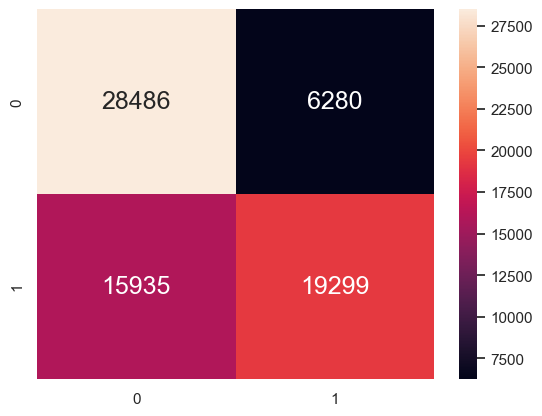

In [26]:
y_train_pred = dectree.predict(x_train)
print("Classification Accuracy:", dectree.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Check accuracy of model on test data

Classification Accuracy: 0.49996666666666667
TPR: 0.36611405835543764
TNR: 0.635254691689008

FPR: 0.36474530831099194
FNR: 0.6338859416445624


<AxesSubplot:>

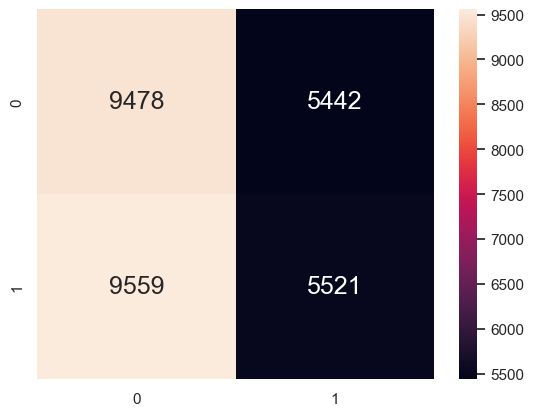

In [27]:
y_test_pred = dectree.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Analysis
As we reduced the number of entries, we could increase the depth of our tree. The increased depth made our model perform significantly better on train data, but worse on test data. Despite trying to simplify our model by removing predictors, overfitting still seems to be a problem.

---
### Creating The Machine Learning Model: Attempt 4
Let's try using `RandomForestClassifier`, another tree based classifier that uses many trees. By combining multiple decision trees to make predictions, hopefully we can create a better prediction model.

---
### Experiment 1:

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 4)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=4)

Classification Accuracy: 0.5197142857142857
TPR: 0.9182448690728946
TNR: 0.11371304974765681

FPR: 0.8862869502523432
FNR: 0.08175513092710544


<AxesSubplot:>

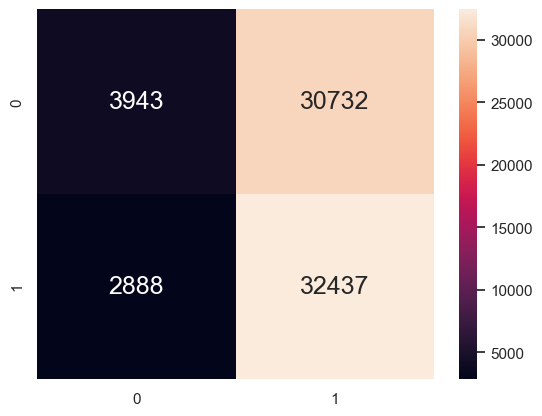

In [29]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6282333333333333
TPR: 0.49176062445793584
TNR: 0.7645060289121312

FPR: 0.2354939710878689
FNR: 0.5082393755420642


<AxesSubplot:>

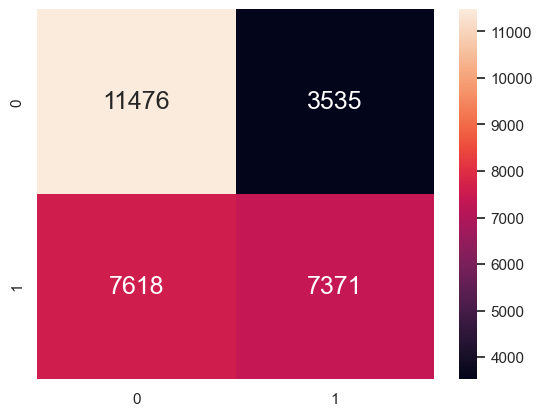

In [30]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Experiment 2: Increase Number of Decision Trees (n_estimators)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 1000, max_depth = 4)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=4, n_estimators=1000)

Classification Accuracy: 0.5239428571428572
TPR: 0.82724016374801
TNR: 0.21757983000229728

FPR: 0.7824201699977027
FNR: 0.17275983625198998


<AxesSubplot:>

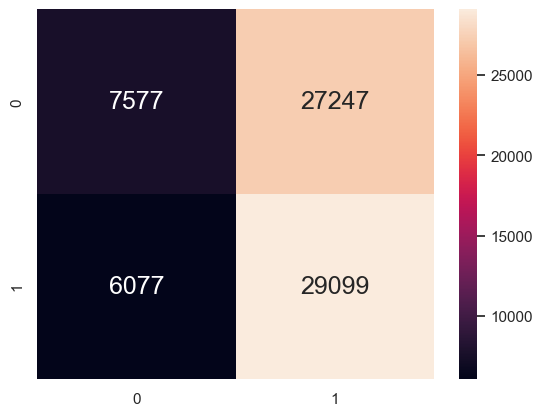

In [34]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6265333333333334
TPR: 0.4901572202404545
TNR: 0.7654420670165523

FPR: 0.2345579329834477
FNR: 0.5098427797595455


<AxesSubplot:>

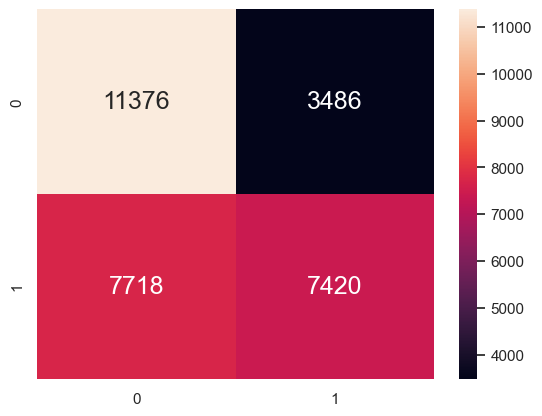

In [35]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Experiment 3: Increase Depth of Decision Trees (max_depth)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 16)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=16)

Classification Accuracy: 0.7003857142857143
TPR: 0.6704830257461837
TNR: 0.7304803944049529

FPR: 0.269519605595047
FNR: 0.3295169742538164


<AxesSubplot:>

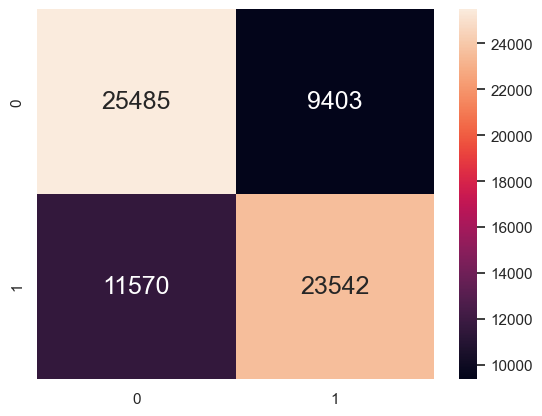

In [38]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6243
TPR: 0.49217208262070783
TNR: 0.760035139883768

FPR: 0.23996486011623192
FNR: 0.5078279173792922


<AxesSubplot:>

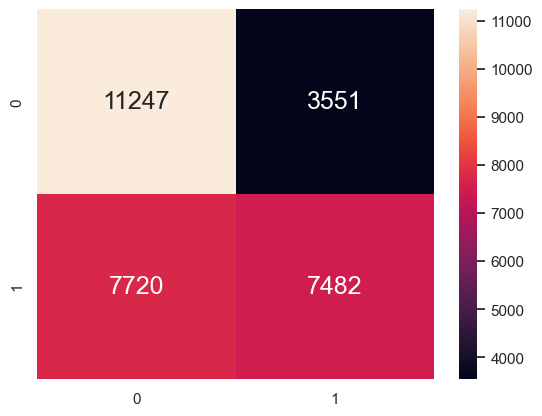

In [39]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Experiment 4: Increase both Number and Depth of Decision Trees

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 1000, max_depth = 16)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=16, n_estimators=1000)

Classification Accuracy: 0.7426428571428572
TPR: 0.7184673152415088
TNR: 0.7670320840268611

FPR: 0.23296791597313896
FNR: 0.2815326847584912


<AxesSubplot:>

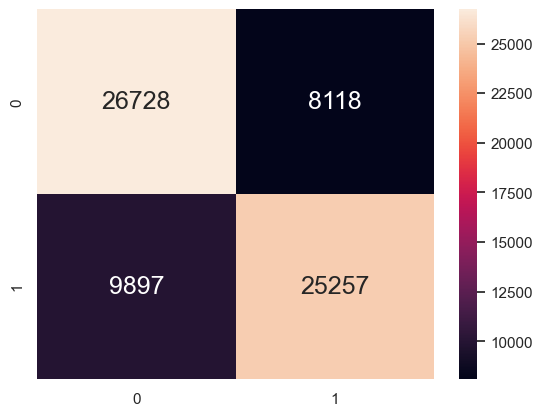

In [44]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6268333333333334
TPR: 0.4931398416886544
TNR: 0.7634097035040431

FPR: 0.23659029649595686
FNR: 0.5068601583113457


<AxesSubplot:>

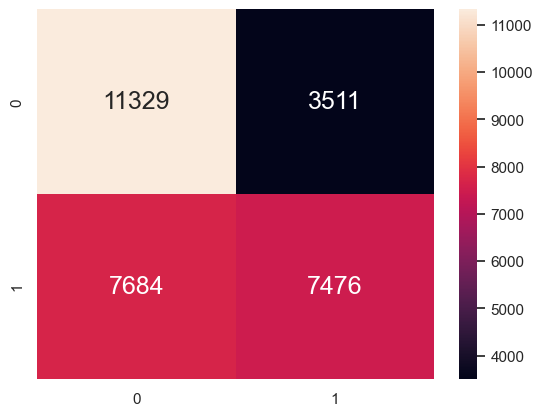

In [45]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", dectree.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Analysis
In the experiments above, we try to vary the number and depth of our decision trees to see how they affect classification accuracy.
> **Experiment 1:** `n_estimators = 100` & `max_depth = 4`  
Classification accuracy for train data was bad, while that for test data was better. There is also a huge imbalance in FPR and FNR in train data. It performed better on test than train, which meant that we underfitted.

> **Experiment 2:** `n_estimators = 1000` & `max_depth = 4`
Classification accuracy for train data improved slightly, but is still quite bad because it faces the same issue of a huge imbalance in FPR and FNR as in Experiment 1. It performed better on test than train, which meant that we underfitted again.

> **Experiment 3:** `n_estimators = 100` & `max_depth = 16`
Classification accuracy for both train and test data have improved significantly. There are also no more huge imbalances in FPR and FNR - their absolute values are not as high as before. This time, we overfitted because the model did better on train than test.

> **Experiment 4:** `n_estimators = 1000` & `max_depth = 16`
Classification accuracy for both train and test data is by far the highest of all previous experiments, including the attempts performed using `DecisionTreeClassifier`. Although the model does a little bit better on train data than test data, this is something to be expected as its impossible to guarentee that the model does as well as it does on test as it does on train data. Our overall analysis shows that by increasing both `n_estimators` & `max_depth` to a certain extent, the model performs better overall on both train and test data.

### Creating The Machine Learning Model: Attempt 5
Learning from our previous attempts, we are either overfitting, or underfiting. To try and fix this we need to tune our hyperparameters. There are 2 parameters that can be tuned: `n_estimators` & `max_depth`. To tune them, we will use `GridSearchCV`, which is a cross-validation tool. It will try to find the optimal values to put for our 2 parameters. We don't want to check every single value i.e. n_estimators from 100, 101, 102... because it is too inefficient, so we will test by intervals.

The first run will use the `scoring` parameter of `accuracy`. But to try something new, on our second run we will use a new scoring called `f1` which takes into account the FPR, FNR and also handles uneven class distributions well, such as when there are different number of `True` & `False` values.

---
### Run 1: Accuracy
For our intervals, we will try checking `n_estimators` from 100 to 1000, incrementing by 300 (100, 400, 700, 1000), and `max_depth` from 4 to 16, incrementing by 4 (4, 8, 12, 16).

In [46]:
param_grid = {'n_estimators': np.arange(100, 1001, 300), 'max_depth': np.arange(4, 17, 4)}
hpGrid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = 'accuracy')
hpGrid.fit(x_train, y_train.winner.ravel())
print(hpGrid.best_estimator_)

RandomForestClassifier(max_depth=12, n_estimators=1000)


Let's use the recommended model to see how well it performs.

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 1000, max_depth = 12)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=12, n_estimators=1000)


Classification Accuracy: 0.6411428571428571
TPR: 0.6611668989844395
TNR: 0.6209429793095532

FPR: 0.37905702069044683
FNR: 0.3388331010155605


<AxesSubplot:>

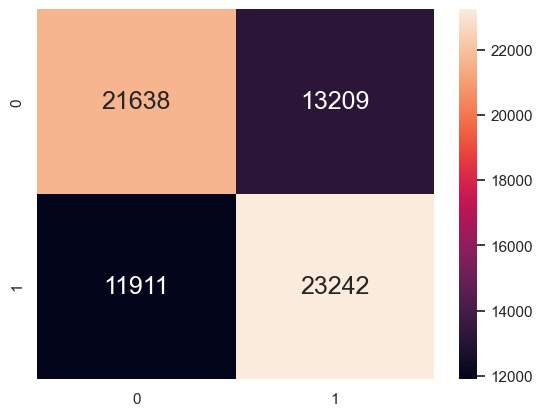

In [48]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6493285714285715
TPR: 0.7868903562218381
TNR: 0.5094921211073661

FPR: 0.49050787889263386
FNR: 0.21310964377816194


<AxesSubplot:>

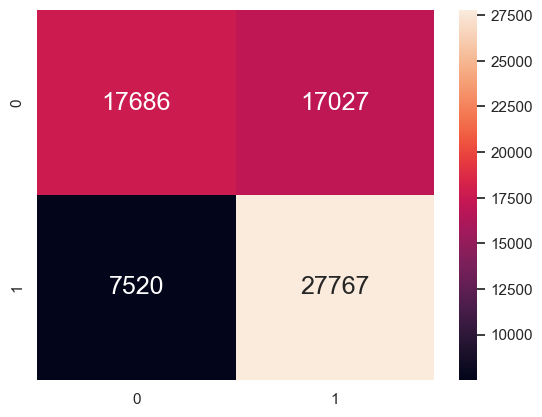

In [49]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", rforest.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Run 2: F1 Score
We do the same now for F1 Score.

In [50]:
param_grid = {'n_estimators': np.arange(1000, 1001, 300), 'max_depth': np.arange(4, 17, 4)}
hpGrid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = 'f1')
hpGrid.fit(x_train, y_train.winner.ravel())
print(hpGrid.best_estimator_)

RandomForestClassifier(max_depth=16)


In [51]:
print(hpGrid.best_estimator_.n_estimators)

1000


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
rforest = RandomForestClassifier(n_estimators = 1000, max_depth = 16)
rforest.fit(x_train, y_train.winner.ravel())

RandomForestClassifier(max_depth=16, n_estimators=1000)

Classification Accuracy: 0.7330714285714286
TPR: 0.8431021752711989
TNR: 0.6216868855286609

FPR: 0.37831311447133903
FNR: 0.15689782472880104


<AxesSubplot:>

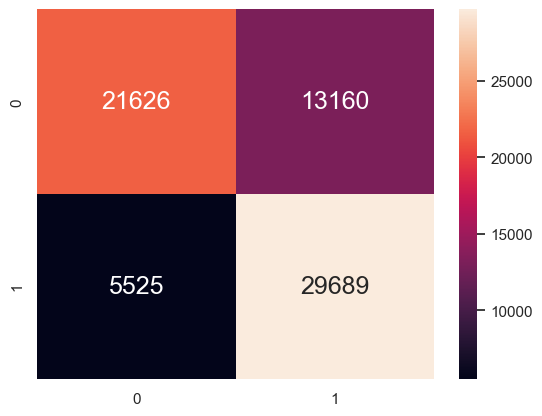

In [53]:
y_train_pred = rforest.predict(x_train)
print("Classification Accuracy:", rforest.score(x_train, y_train))
cm_train = confusion_matrix(y_train, y_train_pred)
tp_train = cm_train[1][1]
fp_train = cm_train[0][1]
tn_train = cm_train[0][0]
fn_train = cm_train[1][0]
print("TPR:", (tp_train / (tp_train + fn_train)))
print("TNR:", (tn_train / (tn_train + fp_train)))
print()
print("FPR:", (fp_train / (tn_train + fp_train)))
print("FNR:", (fn_train / (tp_train + fn_train)))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

Classification Accuracy: 0.6828857142857143
TPR: 0.723734635364919
TNR: 0.6415034653322981

FPR: 0.3584965346677019
FNR: 0.27626536463508106


<AxesSubplot:>

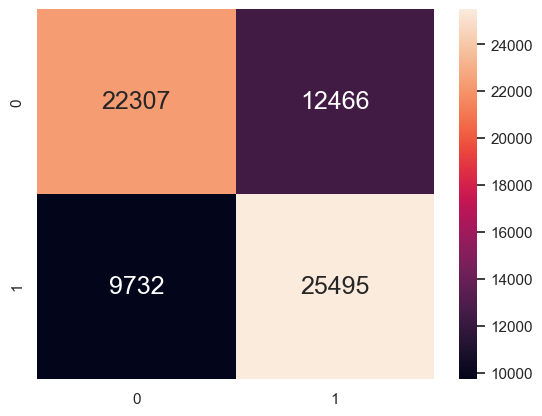

In [54]:
y_test_pred = rforest.predict(x_test)
print("Classification Accuracy:", rforest.score(x_test, y_test))
cm_test = confusion_matrix(y_test, y_test_pred)
tp_test = cm_test[1][1]
fp_test = cm_test[0][1]
tn_test = cm_test[0][0]
fn_test = cm_test[1][0]
print("TPR:", (tp_test / (tp_test + fn_test)))
print("TNR:", (tn_test / (tn_test + fp_test)))
print()
print("FPR:", (fp_test / (tn_test + fp_test)))
print("FNR:", (fn_test / (tp_test + fn_test)))
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = ".0f", annot_kws = {"size": 18})

### Analysis
Using the best model through `GridSearchCV` gave us relatively good classification accuracy. Our first run told us to use `max_depth=12`, but our second run using f1 score told us to use `max_depth=16`. Perhaps the optimal value for this parameter lies somewhere between the two, but due to problematic factors like computational time constraints, finding that precise number would be too much of a hassle. In our first run, classification accuracy for train and test were very close - that is good! In our second run, our model did a bit better in train than test, meaning we overfitted.
### Conclusion
Admittedly, there are some random elements involved in finding the best model in this project, such as the random sample taken from the 8 million+ original entries of data to reduce computational time, or the random splitting of our data into train and test sets. To prevent any form of overfitting or underfitting 100% of the time would be highly impractical. For example, we could have let `GridSearchCV` run for an even longer time, with smaller intervals between hyperparameters, but this would take an extremely long computational time which isn't worth it. Therefore, we shall conclude our model building for now. Thanks for following us on our journey in predicting AoE2 games!